In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.sources.video import VideoSource

In [33]:
%matplotlib notebook

In [29]:
video = VideoSource(src=2, width=2000, height=2000)

video.start()

(800, 1280, 2)


<IPython.core.display.Javascript object>


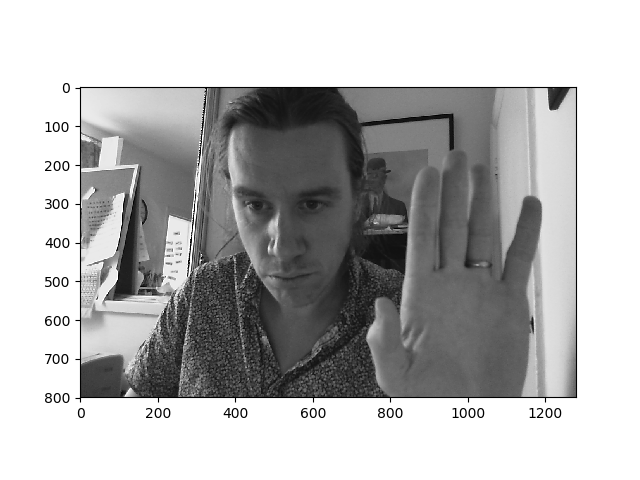

In [35]:
_, frame = video.read(); print(frame.shape)

plt.imshow(frame[:, :, 0], cmap="gray")

In [36]:
image = frame[:, :, 0]

In [57]:
centre = np.asarray(image.shape)//2; print(centre)

[400 640]


In [58]:
final_radius = centre.max(); print(final_radius)

640


In [59]:
def polar2cart(r, theta, center):
    """Convert polar co-ordinates to Cartesian."""
    x = r * np.cos(theta) + center[0]
    y = r * np.sin(theta) + center[1]
    return x, y

def generateLUT(center, final_radius, phase_width=256):
    """Generate a look-up table for polar mapping."""
    initial_radius = 0
    theta, R = np.meshgrid(
        np.linspace(0, 2*np.pi, phase_width),
        np.arange(initial_radius, final_radius)
    )

    Xcart, Ycart = polar2cart(R, theta, center)

    Xcart = Xcart.astype(int)
    Ycart = Ycart.astype(int)
    return (Xcart, Ycart)


def img2polar(img, center, final_radius, LUT, phase_width=256):
    """Map an image to polar co-ordinates."""
    Xcart, Ycart = LUT
    if img.ndim == 3:
        polar_img = img[Ycart, Xcart, :]
        polar_img = np.reshape(
            polar_img, (final_radius, phase_width, 3)
        )
    else:
        polar_img = img[Ycart, Xcart]
        polar_img = np.reshape(
            polar_img, (final_radius, phase_width)
        )

    return polar_img

In [60]:
# https://stackoverflow.com/questions/10871220/making-a-matrix-square-and-padding-it-with-desired-value-in-numpy
def squarify(M, val):
    (a, b)=M.shape
    pad_factor = abs(a-b)//2
    if a < b:
        padding=((pad_factor, pad_factor), (0, 0))
    else:
        padding=((0, 0), (pad_factor, pad_factor))
    return np.pad(M, padding, mode='constant', constant_values=val)

In [61]:
padded = squarify(image, 0); print(padded.shape)

(1280, 1280)


<IPython.core.display.Javascript object>


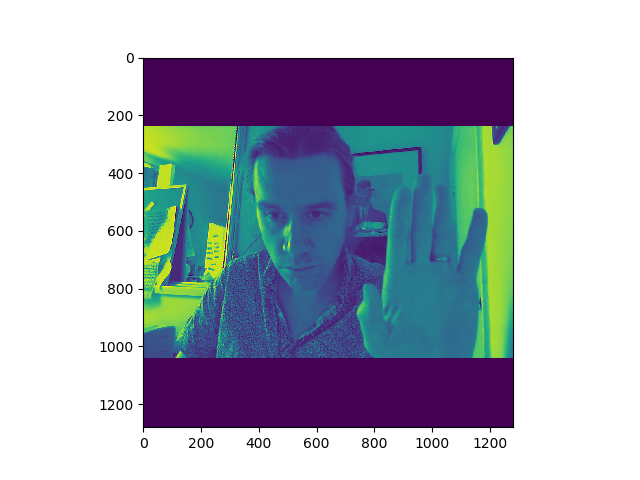

In [62]:
plt.imshow(padded)

In [63]:
LUT = generateLUT(centre, final_radius, phase_width=1024)

In [64]:
output = img2polar(padded, centre, final_radius, LUT, phase_width=1024)

<IPython.core.display.Javascript object>


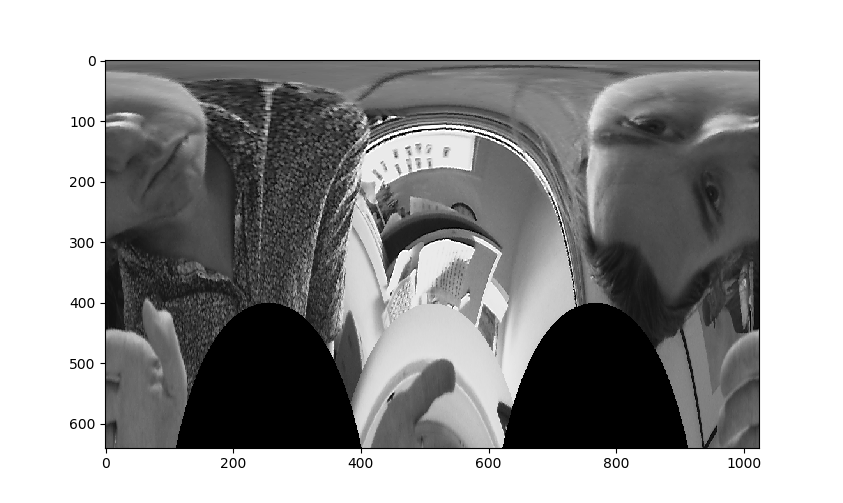

In [65]:
plt.imshow(output, cmap="gray", aspect="auto")

In [46]:
print(f"Centre is at: {centre}. Maximum radius is: {final_radius}")

Centre is at: [400 640]. Maximum radius is: 640


That centre section seems wrong...

<IPython.core.display.Javascript object>


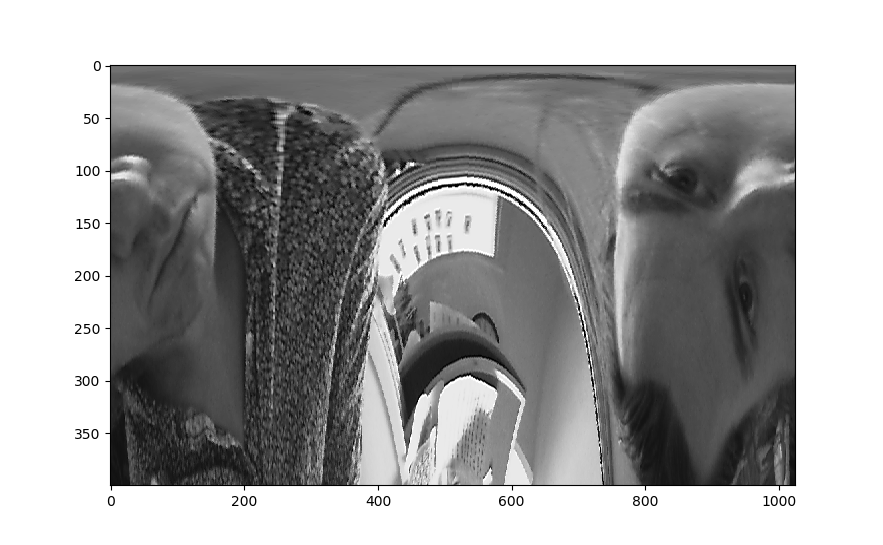

In [53]:
final_radius = 400
LUT = generateLUT(centre, final_radius, phase_width=1024)
output = img2polar(padded, centre, final_radius, LUT, phase_width=1024)
plt.imshow(output, cmap="gray", aspect="auto")

In [66]:
video.stop()

# Reduction in Resolution in Radius

https://stackoverflow.com/questions/22436502/how-to-implement-the-gradient-gaussian-blur

We have a computation that gives us the resolution along R.

So we perform averaging or pooling based on the number of pixels to combine.

In a for loop you would:
* loop over r
* for each r, sum/max groups of n pixels
* save as a list of different sized arrays
* replace groups by the computed sum/max for better visualisation

In [68]:
x_range = np.arange(0, output.shape[0])
pixel_groups = ((output.shape[1] / 64) * (1+0.1*x_range)).astype(np.uint16)
print(pixel_groups)

[  16   17   19   20   22   24   25   27   28   30   32   33   35   36
   38   40   41   43   44   46   48   49   51   52   54   56   57   59
   60   62   64   65   67   68   70   72   73   75   76   78   80   81
   83   84   86   88   89   91   92   94   96   97   99  100  102  104
  105  107  108  110  112  113  115  116  118  120  121  123  124  126
  128  129  131  132  134  136  137  139  140  142  144  145  147  148
  150  152  153  155  156  158  160  161  163  164  166  168  169  171
  172  174  176  177  179  180  182  184  185  187  188  190  192  193
  195  196  198  200  201  203  204  206  208  209  211  212  214  216
  217  219  220  222  224  225  227  228  230  232  233  235  236  238
  240  241  243  244  246  248  249  251  252  254  256  257  259  260
  262  264  265  267  268  270  272  273  275  276  278  280  281  283
  284  286  288  289  291  292  294  296  297  299  300  302  304  305
  307  308  310  312  313  315  316  318  320  321  323  324  326  328
  329 

Values over 1024/2 = 512 don't make sense.

In [70]:
np.argmax(pixel_groups > 512), pixel_groups.shape

(311, (640,))

In [71]:
# Slower non-vectorised function to reduce resolution
reduced_arrays = list()
for row, pixel_group in zip(output, pixel_groups):
    # Set an offset of spacing//2 so we select in centre of space
    reduced_arrays.append(
        row.reshape(-1, pixel_group).mean()
    )

ValueError: cannot reshape array of size 1024 into shape (17)

Ah but all our values need to be factors of the size. So we want to round to the nearest power of 2.

In [75]:
np.log2(pixel_groups).astype(np.uint8)

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [74]:
2**np.log2(pixel_groups).astype(np.uint8)

array([ 16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

We can do the above and just select the non-zero values. We don't need to worry about the speed because we can pre-compute this array. We can also maybe take the ceil rather than the floor...

In [82]:
spacing = 2**np.log2(pixel_groups).astype(np.uint16)

spacing[spacing < output.shape[1]]

array([ 16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 25

In [83]:
spacing = 2**np.ceil(np.log2(pixel_groups)).astype(np.uint16)

spacing[spacing < output.shape[1]]

array([ 16,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
       512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 51

In [85]:
np.around(np.log2(1+0.1*x_range))

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [86]:
np.ceil(np.log2(1+0.1*x_range))

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

<IPython.core.display.Javascript object>


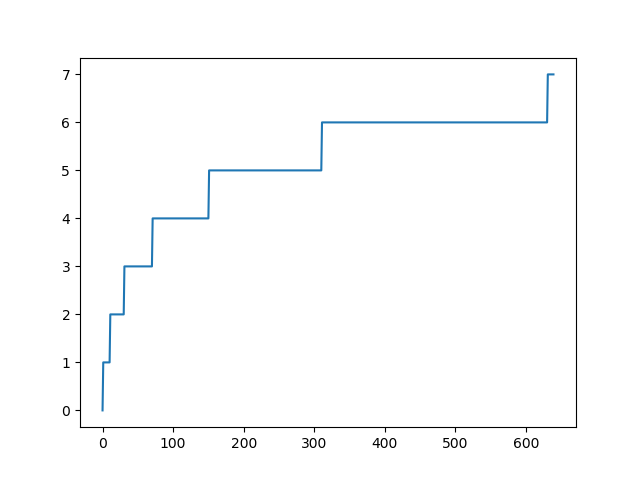

In [88]:
plt.plot(np.ceil(np.log2(1+0.1*x_range)))

We don't need to know the individual values - just the formula for the number of points at each step.

In [90]:
np.unique(np.ceil(np.log2(1+0.1*x_range)), return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([  1,  10,  20,  40,  80, 160, 320,   9]))

Just a doubling!

In [93]:
np.unique((np.log2(1+0.1*x_range)).astype(np.uint16), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint16),
 array([ 10,  20,  40,  80, 160, 320,  10]))

Taking ceil or using int16 just shifts the counts.

So for ceil, we would:
* Compute (shape/2^6) - this is the base grouping.
* Then compute output with the base grouping.
* Then skip the first x values and repeat on the remainer with base grouping\*2.
* Then repeat but skipping the first 2x values.
* Repeat for groupings up to log2(shape)-1.

Groupings are range(log2(shape)-6 to log2(shape)-1).

In [108]:
spacings = 2**(np.arange(0, 7))*5; print(spacings)

[  5  10  20  40  80 160 320]


In [109]:
np.cumsum(spacings)

array([  5,  15,  35,  75, 155, 315, 635])

In [110]:
grouping = 2**(np.arange(0, 7)+4); print(grouping)

[  16   32   64  128  256  512 1024]


In [165]:
base_power = int(np.log2(output.shape[1])); print(base_power)

start_group = (base_power-6); start_group

groupings = 2**(np.arange(start_group, base_power)); print(grouping)

spacings = 2**(np.arange(0, groupings.shape[0]))*5; print(spacings)

spacing_ranges = [np.arange(0, output.shape[1], g) for g in groupings]

start = 0
output_list = list()
for i in range(groupings.shape[0]):
    print(f"Grouping: {groupings[i]}. Range: {start}:{start + spacings[i]}\n")
    reduced = np.add.reduceat(output[start:start + spacings[i], :], spacing_ranges[i], axis=1) // groupings[i]
    print(f"Shape of reduced: {reduced.shape}\n")
    output_list.append(reduced)
    start += spacings[i]

10
512
[  5  10  20  40  80 160]
Grouping: 16. Range: 0:5

Shape of reduced: (5, 64)

Grouping: 32. Range: 5:15

Shape of reduced: (10, 32)

Grouping: 64. Range: 15:35

Shape of reduced: (20, 16)

Grouping: 128. Range: 35:75

Shape of reduced: (40, 8)

Grouping: 256. Range: 75:155

Shape of reduced: (80, 4)

Grouping: 512. Range: 155:315

Shape of reduced: (160, 2)



But we also need to apply the offset?

In [166]:
spacing_ranges

[array([   0,   16,   32,   48,   64,   80,   96,  112,  128,  144,  160,
         176,  192,  208,  224,  240,  256,  272,  288,  304,  320,  336,
         352,  368,  384,  400,  416,  432,  448,  464,  480,  496,  512,
         528,  544,  560,  576,  592,  608,  624,  640,  656,  672,  688,
         704,  720,  736,  752,  768,  784,  800,  816,  832,  848,  864,
         880,  896,  912,  928,  944,  960,  976,  992, 1008]),
 array([  0,  32,  64,  96, 128, 160, 192, 224, 256, 288, 320, 352, 384,
        416, 448, 480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800,
        832, 864, 896, 928, 960, 992]),
 array([  0,  64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768,
        832, 896, 960]),
 array([  0, 128, 256, 384, 512, 640, 768, 896]),
 array([  0, 256, 512, 768]),
 array([  0, 512])]

In [164]:
spacing_ranges[0].shape

(205,)

In [120]:
len(output_list)

6

In [122]:
output_list[0].shape

(5, 2)

In [123]:
output.shape

(640, 1024)

In [126]:
output[0:5, :].shape

(5, 1024)

In [129]:
reduced = np.add.reduceat(output[0:5, :], np.arange(0, output.shape[1], 16), axis=1)

In [130]:
reduced.shape

(5, 64)

In [132]:
1024/16

64.0

In [135]:
output[0:5, :]

array([[114, 114, 114, ..., 114, 114, 114],
       [113, 114, 114, ..., 115, 115, 113],
       [113, 113, 113, ..., 114, 114, 113],
       [113, 113, 113, ..., 114, 114, 113],
       [114, 113, 113, ..., 115, 115, 114]], dtype=uint8)

In [134]:
reduced // 16

array([[1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824,
        1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824,
        1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824,
        1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824,
        1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824,
        1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824],
       [1823, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824, 1824,
        1824, 1824, 1824, 1824, 1824, 1840, 1840, 1840, 1840, 1840, 1840,
        1840, 1840, 1840, 1840, 1840, 1840, 1840, 1840, 1840, 1840, 1872,
        1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872,
        1872, 1872, 1872, 1872, 1840, 1840, 1840, 1840, 1840, 1840, 1840,
        1840, 1840, 1840, 1840, 1840, 1840, 1840, 1840, 1838],
       [1808, 1808, 1808, 1808, 1808, 1778, 1760, 1760, 1760, 1760, 1765,
        1776, 1776, 1776, 1776, 1776, 1760, 1760, 1760, 1760

<IPython.core.display.Javascript object>


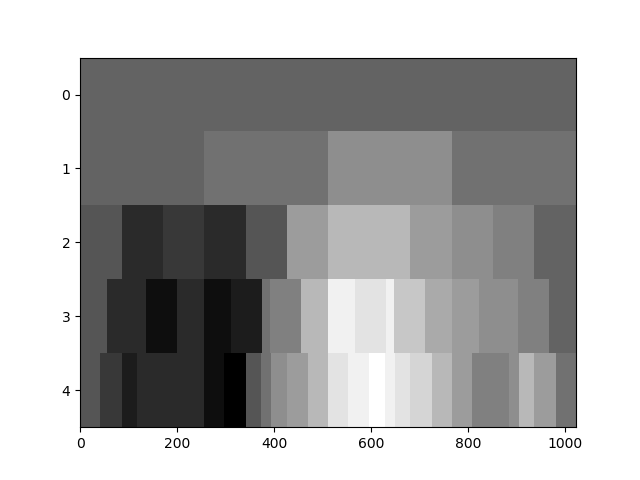

In [167]:
plt.imshow(output[0:5, :], aspect="auto", cmap="gray")

<IPython.core.display.Javascript object>


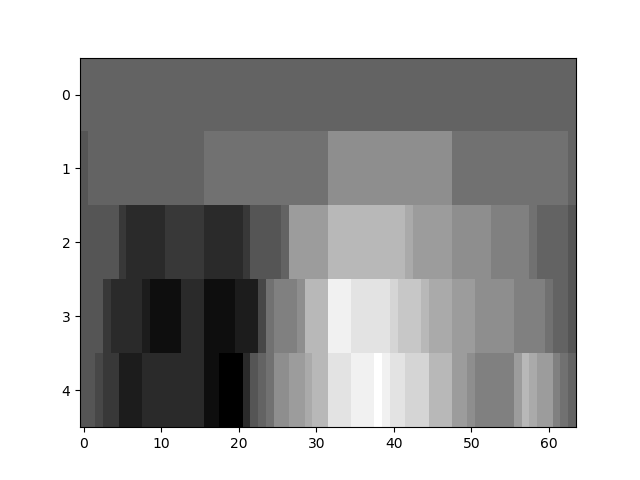

In [168]:
plt.imshow(output_list[0], aspect="auto", cmap="gray")

In [162]:
output_list[0]

array([[35, 35, 35, ..., 35, 35, 28],
       [35, 35, 35, ..., 35, 35, 28],
       [35, 35, 35, ..., 35, 35, 28],
       [35, 35, 35, ..., 35, 35, 28],
       [35, 35, 35, ..., 35, 35, 28]], dtype=uint64)

<IPython.core.display.Javascript object>


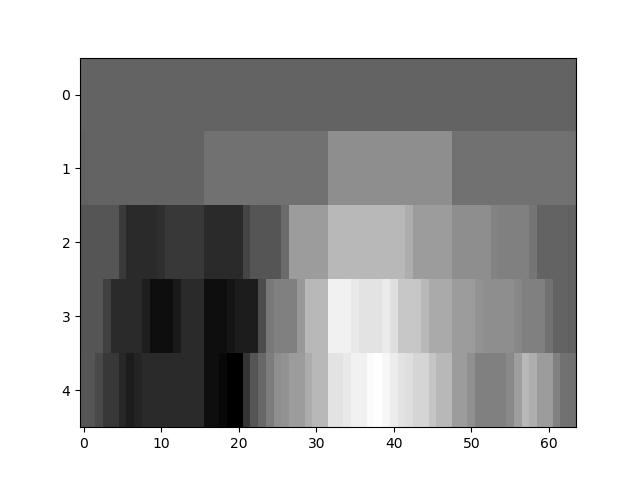

In [138]:
plt.imshow(reduced, aspect="auto", cmap="gray")

In [147]:
reduced2 = np.add.reduceat(output[5:15, :], np.arange(0, output.shape[1], 32), axis=1)

<IPython.core.display.Javascript object>


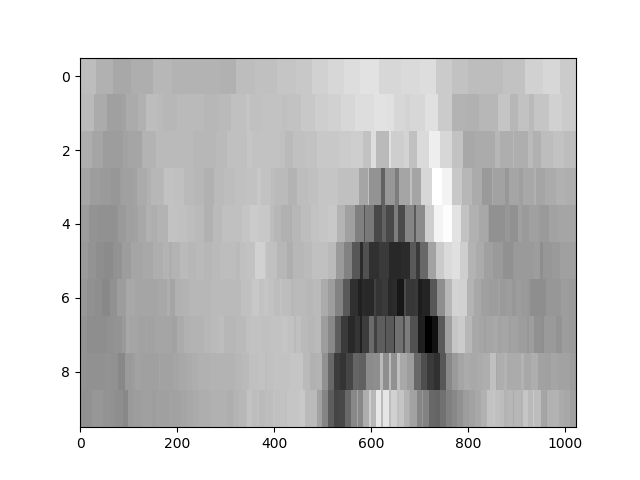

In [149]:
plt.imshow(output[5:15, :], aspect="auto", cmap="gray")

<IPython.core.display.Javascript object>


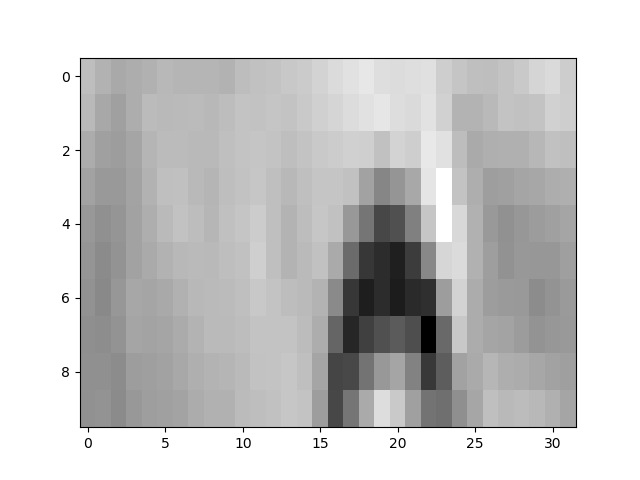

In [150]:
plt.imshow(reduced2, aspect="auto", cmap="gray")

This seems to be aligning the image portions okay. Now let's try a function that takes the list and creates an image of output size as one array (effectively interpolates between the values). We can use the interpolation function for the sensor input.

In [151]:
def resize(array, elem_num):
    """Linearly scale array.

    Arg:
        elem_num - integer number of new elements in array.
    """
    old_length = array.shape[0]
    x = np.linspace(0, old_length-1, elem_num)
    xp = np.linspace(0, old_length-1, old_length)
    return np.interp(x, xp, array.flatten()).reshape(-1, 1)

Ah this is only for 1D. It might be faster if we only need this for display to just copy the average value into the spacings. It might be better to do this at the same time as reducing...

In [152]:
resized = resize(reduced2, output.shape[1])

ValueError: fp and xp are not of the same length.

We can use np.repeat to repeat along the axis

In [173]:
output_display = np.repeat(output_list[0], 16, axis=1)

In [174]:
output_display.shape

(5, 1024)

<IPython.core.display.Javascript object>


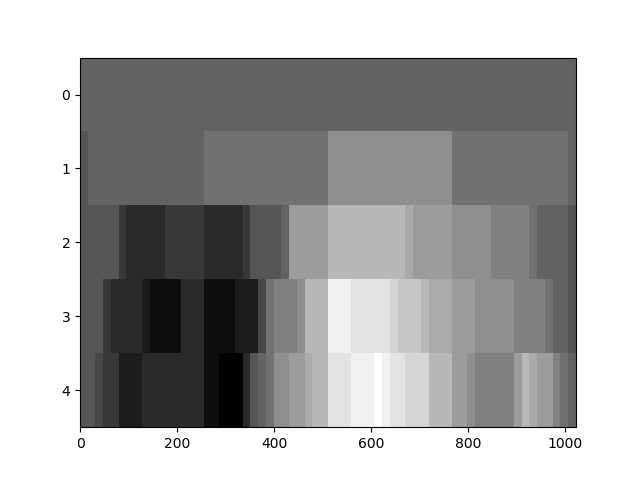

In [175]:
plt.imshow(output_display, aspect="auto", cmap="gray")

<IPython.core.display.Javascript object>


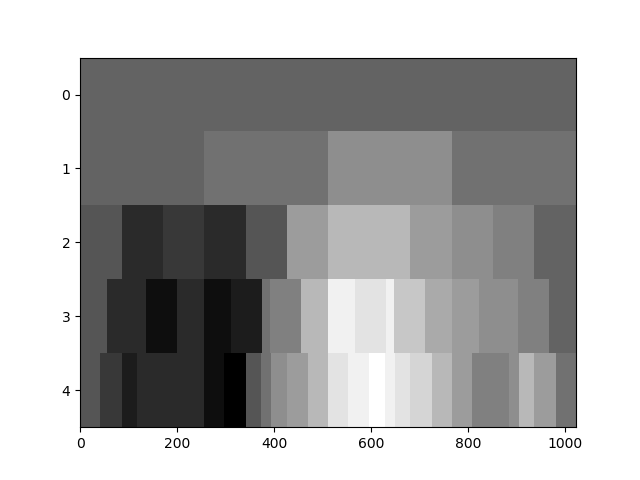

In [176]:
plt.imshow(output[0:5], aspect="auto", cmap="gray")

***Actually, if they all have a spacing of at least 16, we need to set the initial spacing much lower!!!!***

In [184]:
LUT2 = generateLUT(centre, final_radius, phase_width=64)
output2 = img2polar(padded, centre, final_radius, LUT2, phase_width=64)

<IPython.core.display.Javascript object>


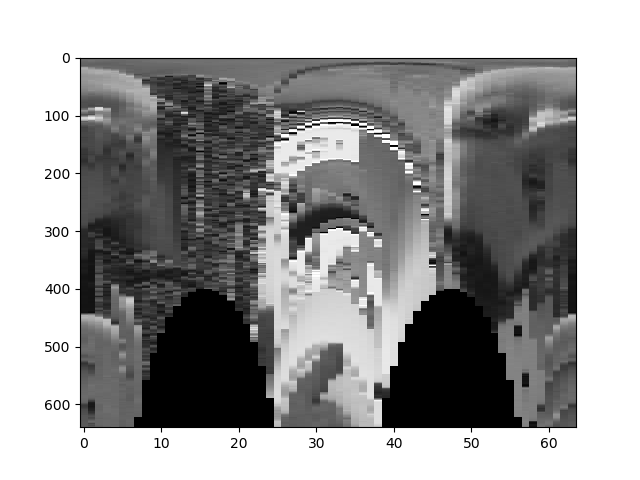

In [182]:
plt.imshow(output2, aspect="auto", cmap="gray")

```
    base_power = int(np.log2(output.shape[1])); print(base_power)

    start_group = (base_power-6); start_group

    groupings = 2**(np.arange(start_group, base_power)); print(grouping)

     spacings = 2**(np.arange(0, groupings.shape[0]))*5; print(spacings)

    spacing_ranges = [np.arange(0, output.shape[1], s) for s in spacings]

    start = 0
    output_list = list()
    for i in range(groupings.shape[0]):
        print(f"Grouping: {groupings[i]}. Range: {start}:{start + spacings[i]}\n")
        reduced = np.add.reduceat(output[start:start + spacings[i], :], spacing_ranges[i], axis=1) // groupings[i]
        print(f"Shape of reduced: {reduced.shape}\n")
        output_list.append(reduced)
        start += spacings[i]
```

In [209]:
def setup_reduced_res(image):
    """Generate data for reducing resolution."""
    # Get width of image as a power of 2
    base_power = int(np.log2(image.shape[1]))
    # Highest resolution is set by rough science
    start_group = (base_power-6)
    # Determine the number of pixels to group
    # across the angular (rotation) dimension
    groupings = 2**(np.arange(start_group, base_power))
    # Determine the ends of the ranges for the different groups
    spacings = 2**(np.arange(0, groupings.shape[0]))*5
    # Determine the ranges outside of the loop
    grouping_ranges = [
        np.arange(0, image.shape[1], g) for g in groupings
    ]
    return groupings, grouping_ranges, spacings

def reduce_resolution(image, output_display=False):
    """Reduce resolution as per visual acuity.
    
    Args:
        image - 2D numpy array in polar domain - width (cols) - needs to be a power of 2.
        output_display - boolean indicating whether to calculate an output image for display.
    
    Returns:
        tuple of:
            output_list - list of reduced image portions.
            output_image - image for display if output_display = True.
    """
    groupings, grouping_ranges, spacings = setup_reduced_res(image)
    # Build a list of different resolutions
    start = 0
    output_list = list()
    if output_display:
        shape = (spacings.sum(), image.shape[1])
        output_image = np.zeros(shape=shape, dtype=image.dtype)
    else:
        output_image = None
    # Loop over the groupings
    for i in range(groupings.shape[0]):
        # Average over each set of groupings and add to list
        reduced = np.add.reduceat(image[start:start + spacings[i], :], grouping_ranges[i], axis=1) // groupings[i]
        output_list.append(reduced)
        # If output_display flag is set, generate an image for output
        if output_display:
            output_image[start:start + spacings[i], :] = np.repeat(reduced, groupings[i], axis=1)  
        # Set the start of the next range as the end of the previous range
        start += spacings[i]
    # Return outputs
    return output_list, output_image
        
def test_reduce_resolution():
    """Test function to reduce resolution."""
    pass

In [210]:
output_list, output_image = reduce_resolution(output, output_display=True)

<IPython.core.display.Javascript object>


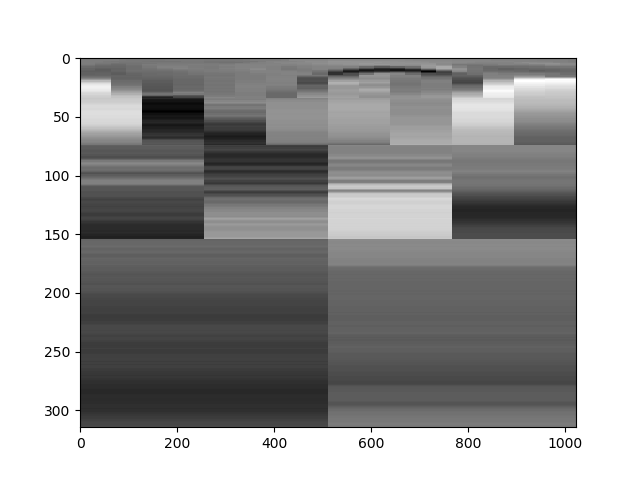

In [211]:
plt.imshow(output_image, aspect="auto", cmap="gray")

In [198]:
spacings

array([  5,  10,  20,  40,  80, 160])

In [199]:
spacings.sum()

315

## Backwards LUT

We can also adapt our backwards LUT method to use meshgrid.

In [212]:
# Original method
def calculatebackLUT(max_radius):
    """Precalculate a lookup table for mapping from x,y to polar."""
    LUT = np.zeros((max_radius*2, max_radius*2, 2), dtype=np.int16)
    # Iterate around x and y
    for row in range(0, max_radius*2):
        for col in range(0, max_radius*2):
            # Translate to centre - minus row makes angle from +ve y axis
            m_row = max_radius - row
            m_col = col - max_radius
            # Calculate angle w.r.t. y axis
            angle = math.atan2(m_col, m_row)
            # Convert to degrees
            degrees = math.degrees(angle)
            # Calculate radius
            radius = math.sqrt(m_row*m_row+m_col*m_col)
            # print(angle, radius)
            LUT[row, col] = [int(radius), int(degrees)]
    return LUT

In [229]:
def cart2polar(row, col):
    """Convert cartesian co-ordinates to polar."""
    # Compute angle in radians
    angle = np.arctan2(col, row)
    # Compute radius
    radius = np.sqrt(row**2+col**2)
    return radius, angle

# Original method
def generateBackLUT(max_radius):
    """Precalculate a lookup table for mapping from x,y to polar.
    
    Assumes a centre at 0, 0 - need to translate when back converting.
    
    Args:
        max_radius - integer representing the maximum radius - 
            forms the LUT height and width.
    Returns:
        LUT - numpy array of shape (rows, cols, 2) that provides 
            the backward mapping.
            
    """
    cart_range = np.arange(-1*max_radius, max_radius)
    row, col = np.meshgrid(
        cart_range,
        cart_range
    )

    radius, angle = cart2polar(row, col)

    radius = radius.astype(int)
    # Create a new LUT of shape (radius, angle, 2)
    backLUT = np.stack([radius, angle], axis=-1)
    return backLUT

In [230]:
backLUT = generateBackLUT(400)

In [231]:
backLUT.shape

(800, 800, 2)

It should be a similar operation to translate back.

<IPython.core.display.Javascript object>


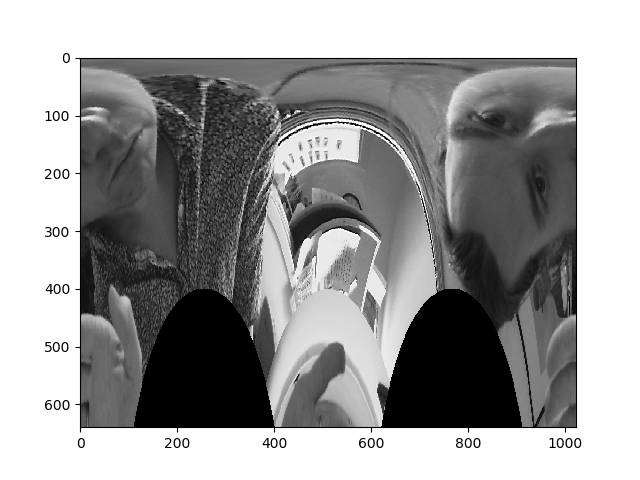

In [219]:
plt.imshow(output, cmap="gray", aspect="auto")

In [220]:
def convert_image(image, LUT):
    """Precalculate a lookup table with the image maths."""
    # Determine image size
    rows, cols = image.shape[:2]
    # Use centre of image as origin
    centre_row = rows // 2
    centre_col = cols // 2
    # Determine LUT size
    max_radius, angles, _ = LUT.shape
    # Determine radius
    radius = min(max_radius, centre_row, centre_col)
    # Adjust LUT to centre and clip so indices are within bounds
    rows = np.clip(centre_row - LUT[..., 0], 0, centre_row+radius-1)
    cols = np.clip(centre_col + LUT[..., 1], 0, centre_col+radius-1)
    # If multiple components
    if image.ndim == 3:
        output = image[rows, cols, :]
    else:
        output = image[rows, cols]
    # Crop based on min radius
    return output[:radius, ...]

In [261]:
def back_convert_image(polar_image, backLUT):
    """Convert a polar image to cartesian using the backLUT.
    
    Output image is square with dimensions 2*radius in each dimension.
    
    
    Args:
        polar_image - numpy array with radius along rows and angles along columns.
        backLUT - a numpy array generated as above.
    Returns:
        output_image - a numpy array representing the cartesian image.
        
    """
    # Determine image size
    range_radius, range_angles = polar_image.shape[:2]
    # Determine LUT size
    rows, cols, _ = backLUT.shape
    # Adjust radius so it is within the scale of the polar image
    radius = np.clip(backLUT[..., 0], 0, range_radius).astype(int)
    # Convert radian range to discrete pixel range
    angles = ((backLUT[..., 1]+np.pi)*(1/(2*np.pi))*(range_angles-1)).astype(int)
    # If multiple components
    if polar_image.ndim == 3:
        output_image = polar_image[radius, angles, :]
    else:
        output_image = polar_image[radius, angles]
    # Image is upside down so flip the right way around
    return np.flip(output_image)

We want to clip the radius to the range of the polar_image and map the cols to -pi > pi.

In [262]:
back_converted = back_convert_image(output, backLUT)

In [263]:
2*np.pi*(1024-1)//(2*np.pi)

1023.0

<IPython.core.display.Javascript object>


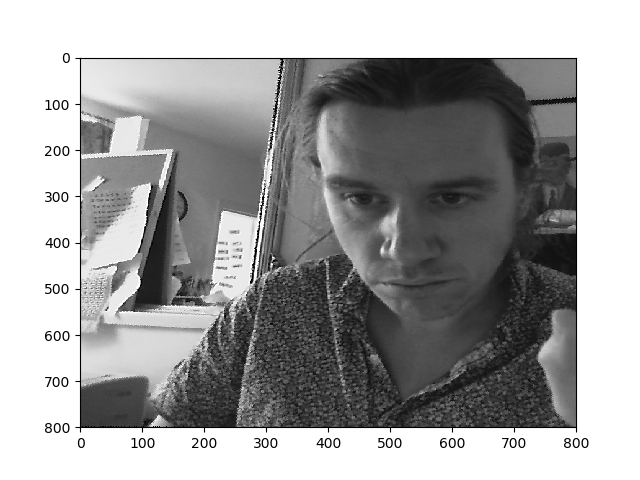

In [264]:
plt.imshow(back_converted, cmap="gray", aspect="auto")

In [233]:
# Radius max and min
backLUT[..., 0].max(), backLUT[..., 0].min()

(565.0, 0.0)

In [234]:
# Angle max and min
backLUT[..., 1].max(), backLUT[..., 1].min()

(3.141592653589793, -3.139092658798107)

Ah - this is why radians has a problem - we need to convert the radians into a pixel resolution.

In [237]:
backLUT[..., 0]

array([[565., 564., 564., ..., 563., 564., 564.],
       [564., 564., 563., ..., 562., 563., 564.],
       [564., 563., 562., ..., 562., 562., 563.],
       ...,
       [563., 562., 562., ..., 561., 562., 562.],
       [564., 563., 562., ..., 562., 562., 563.],
       [564., 564., 563., ..., 562., 563., 564.]])

In [266]:
frame.shape

(800, 1280, 2)

In [270]:
def polar2cart(r, theta):
    """Convert polar co-ordinates to Cartesian."""
    # x = r * np.cos(theta + np.pi/2) + center[0]
    # y = r * np.sin(theta + np.pi/2) + center[1]
    row = r * np.cos(theta)
    col = r * np.sin(theta)
    return row, col

def generateLUT(radius, phase_width=256):
    """Generate a look-up table for polar mapping.

    Args:
        radius - integer specifying radius in pixels.
        phase_width - integer specifying angle resolution.
    """
    theta, R = np.meshgrid(
        np.linspace(0, 2*np.pi, phase_width),
        np.arange(0, radius)
    )

    rows, cols = polar2cart(R, theta)

    rows = rows.astype(int)
    cols = cols.astype(int)
    # Create a new LUT of shape (radius, angle, 2)
    LUT = np.stack([rows, cols], axis=-1)
    return LUT

In [271]:
LUT = generateLUT(400)

In [272]:
forward_converted = convert_image(frame, LUT)

In [273]:
from src.sources.video import separate_components

Y, U, V = separate_components(forward_converted)

<IPython.core.display.Javascript object>


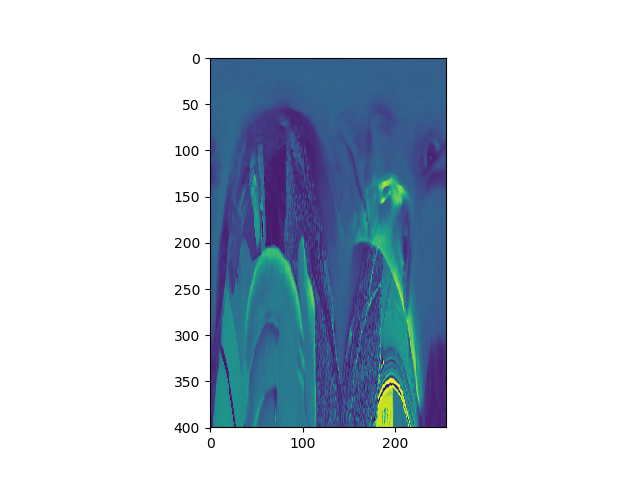

In [274]:
plt.imshow(Y)

<IPython.core.display.Javascript object>


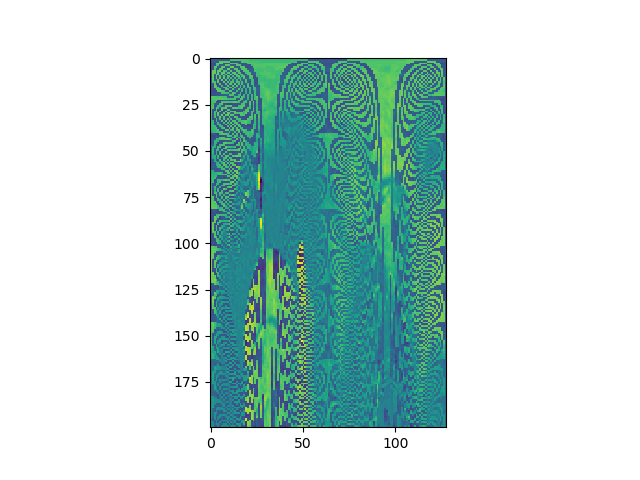

In [275]:
plt.imshow(U)

<IPython.core.display.Javascript object>


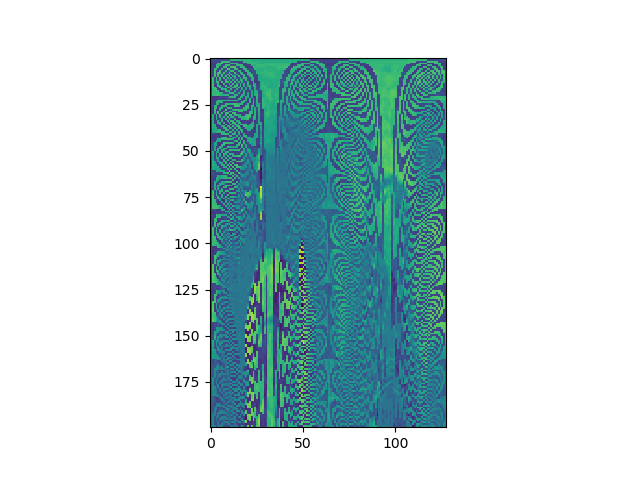

In [276]:
plt.imshow(V)

Ah - that doesn't necessarily work!

We'll need to separate the components first.

In [279]:
def forward_quad(input_data):
    """Split an image into 4.
        
    Args:
        input_data - 2D numpy array with polar image.
    """
    rows, cols = input_data.shape
    right_image = input_data[:, :cols//2].T
    left_image = np.flip(input_data[:, cols//2:].T)
    # Split in half again vertically to show - could replace these with list + for loop
    rows, cols = right_image.shape
    output_images = list()
    output_images.append(right_image[:rows//2, :])
    output_images.append(left_image[:rows//2, :])
    output_images.append(right_image[rows//2:, :])
    output_images.append(left_image[rows//2:, :])
    return output_images

def backward_quad(image_list):
    """Take four images and recombine into one.
    
    Reverses forward_quad.
        
    Args:
        image_list - list of 2D numpy array with each
            quadrant image.
    """
    # Take quadrants [0] and [2] and concatenate along axis 0
    right_image = np.concatenate((image_list[0], image_list[2]), axis=0)
    # Take quadrants [1] and [3] and concatenate along axis 0
    left_image = np.concatenate((image_list[1], image_list[3]), axis=0)
    # Take above results, transpose, flip and concatenate along axis 1
    flipped_right = right_image.T
    flipped_left = np.flip(left_image.T)
    combined_image = np.concatenate((flipped_right, flipped_left), axis=1)
    return combined_image

In [280]:
output_images = forward_quad(frame[:, :, 0])

<IPython.core.display.Javascript object>


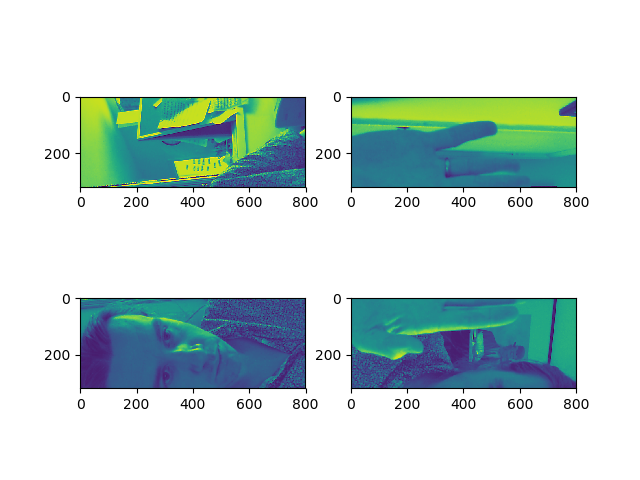

In [281]:
fig, axes = plt.subplots(2, 2)
for ax, img in zip(axes.ravel(), output_images):
    ax.imshow(img)

In [282]:
combined_image = backward_quad(output_images)

<IPython.core.display.Javascript object>


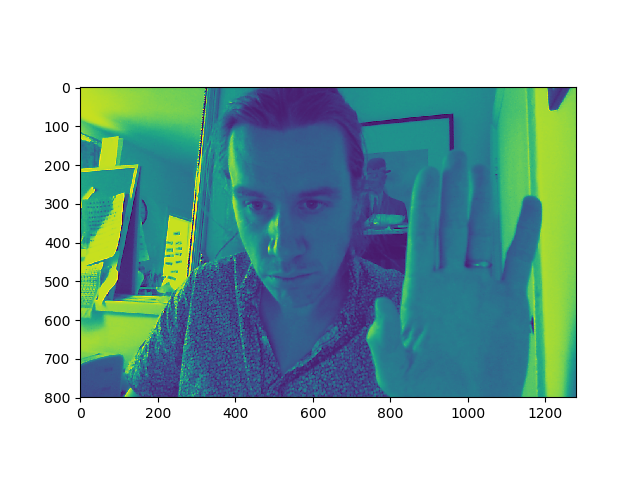

In [283]:
plt.imshow(combined_image)